In [1]:
!pip install torch
!pip install transformers
!pip install evaluate
!pip install datasets
!pip install rouge_score
!pip install torcheval
!pip install timm
!pip install wandb
!pip install nltk



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
import random
import re
import nltk
import evaluate

from transformers import AutoTokenizer,AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import AdamW
from transformers import get_scheduler


from evaluate import load
from tqdm import tqdm
from rouge_score import rouge_scorer
from datasets import load_dataset


import numpy as np
from accelerate import Accelerator
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import default_collate


nltk.download("punkt")
nltk.download('punkt_tab')






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [4]:
# Load the raw dataset (streaming must be False for map-style datasets)
raw_dataset = load_dataset("cnn_dailymail", "3.0.0", streaming=False)

model_name = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
def duplicate_sentence_ratio(text):
    sentences = nltk.sent_tokenize(text)
    if not sentences:
        return 0
    unique = len(set(sentences))
    return 1 - (unique / len(sentences))

# Example: compute duplicate ratio for a sample article
sample_text = raw_dataset["train"][0]["article"]
ratio = duplicate_sentence_ratio(sample_text)
print("Duplicate Sentence Ratio:", ratio)


def special_char_frequency(text, pattern=r"[!@#$%^&*]"):
    matches = re.findall(pattern, text)
    return len(matches) / len(text)  # normalized by text length

sample_text = raw_dataset["train"][0]["article"]
freq = special_char_frequency(sample_text)
print("Special Character Frequency:", freq)

sample_text = raw_dataset["train"][0]["article"]
score = textstat.flesch_reading_ease(sample_text)
print("Flesch Reading Ease Score:", score)






Duplicate Sentence Ratio: 0.0
Special Character Frequency: 0.0003957261574990107


NameError: name 'textstat' is not defined

In [5]:



def clean_text(text):
    # Remove HTML tags, extra spaces, and newline characters
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # collapse multiple spaces/newlines
    return text



# Define preprocessing function
def pre_process(batch):
    inputs = [clean_text(article) for article in batch["article"]]
    targets = [clean_text(summary) for summary in batch["highlights"]]
    # Tokenize and pad to longest sequence in batch; return NumPy arrays.
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding=False, return_tensors="np")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding=False, return_tensors="np")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing with batched mapping and remove unnecessary columns
tokenized_dataset = raw_dataset.map(
    pre_process,
    batched=True,
    remove_columns=["article", "highlights", "id"]
)




Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
train_dataset = tokenized_dataset["train"].shuffle(seed=42)

subset_size = int(0.2 * len(train_dataset))

train_subset = train_dataset.select(range(subset_size))

val_dataset = tokenized_dataset["validation"].shuffle(seed=42)

subset_size = int(0.2* len(val_dataset))

val_subset = val_dataset.select(range(subset_size))






In [7]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define your custom collate function to convert lists of numpy arrays to a single tensor
def custom_collate_fn(features):
    batch = data_collator(features)
    for key, value in batch.items():
        if isinstance(value, list):
            batch[key] = torch.tensor(np.array(value), dtype=torch.int64)
    return batch




In [8]:
# Create DataLoaders using the custom collate function
def loader(batch_size,train_subset,val_subset):
  train_loader = DataLoader(
    train_subset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    pin_memory=True,
    num_workers=10,
    persistent_workers=True,
    prefetch_factor=6
                          )
  val_loader = DataLoader(
    val_subset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    pin_memory=True,
    num_workers=10,
    persistent_workers=True,
    prefetch_factor=6
)
  return train_loader, val_loader






In [9]:
def train_epoch(model, train_loader, optimizer, scheduler, device, scaler):
    model.train()
    total_loss = 0.0
    num_batches = 0
    all_train_preds = []
    all_train_labels = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        with torch.autocast(device_type = "cuda"):
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # Scheduler stepping every batch

        total_loss += loss.item()
        num_batches += 1
        progress_bar.set_description(f"Loss: {loss.item():.4f}")



    avg_loss = total_loss / num_batches
    return avg_loss






In [10]:
def postprocess_text(preds,labels):
  preds= [pred.strip()for pred in preds]
  labels  = [label.strip() for label in labels]

  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels





In [11]:
def evaluate_epoch(model, loader, device, tokenizer, rouge_metric):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

            generated_ids = model.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
            decoded_preds = tokenizer.batch_decode(
                generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            label_fixed = torch.where(batch["labels"] == -100, tokenizer.pad_token_id, batch["labels"])
            decoded_labels = tokenizer.batch_decode(
                label_fixed, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

            all_preds.extend(decoded_preds)
            all_labels.extend(decoded_labels)

    avg_loss = total_loss / num_batches
    rouge_result = rouge_metric.compute(predictions=all_preds, references=all_labels)
    return avg_loss, rouge_result




/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<ipython-input-12-36fe6d6802a4>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


Train Loss: nan


Validation Loss: 1.5195
ROUGE metric output: {'rouge1': 0.44334315284965586, 'rouge2': 0.2224834481006315, 'rougeL': 0.3192342010315614, 'rougeLsum': 0.41595711537506525}
Val ROUGE-1 F1: 0.4433
Val ROUGE-2 F1: 0.2225
Val ROUGE-L F1: 0.3192

Epoch 2/10


Train Loss: 0.9534


Validation Loss: 1.5319
ROUGE metric output: {'rouge1': 0.4419130975965806, 'rouge2': 0.22223480665474962, 'rougeL': 0.31950950654951105, 'rougeLsum': 0.41470144131029774}
Val ROUGE-1 F1: 0.4419
Val ROUGE-2 F1: 0.2222
Val ROUGE-L F1: 0.3195

Epoch 3/10


Train Loss: 0.9201


Validation Loss: 1.5372
ROUGE metric output: {'rouge1': 0.4427161605589711, 'rouge2': 0.22192981021820268, 'rougeL': 0.3189031535703112, 'rougeLsum': 0.41459586583123176}
Val ROUGE-1 F1: 0.4427
Val ROUGE-2 F1: 0.2219
Val ROUGE-L F1: 0.3189

Epoch 4/10


Train Loss: 0.8936


Validation Loss: 1.5541
ROUGE metric output: {'rouge1': 0.44258558329727193, 'rouge2': 0.2217380003420949, 'rougeL': 0.31802409256376635, 'rougeLsum': 0.41526935146283384}
Val ROUGE-1 F1: 0.4426
Val ROUGE-2 F1: 0.2217
Val ROUGE-L F1: 0.3180

Epoch 5/10


Train Loss: 0.8710


Validation Loss: 1.5625
ROUGE metric output: {'rouge1': 0.44218390719817247, 'rouge2': 0.22157267806293462, 'rougeL': 0.31849355289550735, 'rougeLsum': 0.4150108326457381}
Val ROUGE-1 F1: 0.4422
Val ROUGE-2 F1: 0.2216
Val ROUGE-L F1: 0.3185

Epoch 6/10


Train Loss: nan


Validation Loss: 1.5729
ROUGE metric output: {'rouge1': 0.4408739621016222, 'rouge2': 0.21882174995370499, 'rougeL': 0.3159926611551815, 'rougeLsum': 0.41275857535951677}
Val ROUGE-1 F1: 0.4409
Val ROUGE-2 F1: 0.2188
Val ROUGE-L F1: 0.3160

Epoch 7/10


Train Loss: 0.8369


Validation Loss: 1.5824
ROUGE metric output: {'rouge1': 0.44258694026098133, 'rouge2': 0.21996066357435923, 'rougeL': 0.3174129372752618, 'rougeLsum': 0.41507031613928047}
Val ROUGE-1 F1: 0.4426
Val ROUGE-2 F1: 0.2200
Val ROUGE-L F1: 0.3174

Epoch 8/10


Train Loss: 0.8253


Validation Loss: 1.5912
ROUGE metric output: {'rouge1': 0.4433119626721151, 'rouge2': 0.22072358972986822, 'rougeL': 0.31710993972328005, 'rougeLsum': 0.4154192351726426}
Val ROUGE-1 F1: 0.4433
Val ROUGE-2 F1: 0.2207
Val ROUGE-L F1: 0.3171

Epoch 9/10


Train Loss: nan


Validation Loss: 1.5972
ROUGE metric output: {'rouge1': 0.44243318088907535, 'rouge2': 0.22003826419019806, 'rougeL': 0.3177030464695877, 'rougeLsum': 0.41491012407990724}
Val ROUGE-1 F1: 0.4424
Val ROUGE-2 F1: 0.2200
Val ROUGE-L F1: 0.3177

Epoch 10/10


Train Loss: nan


Validation Loss: 1.5993
ROUGE metric output: {'rouge1': 0.4422225976917702, 'rouge2': 0.21919078348583254, 'rougeL': 0.316669177678203, 'rougeLsum': 0.4140505560066492}
Val ROUGE-1 F1: 0.4422
Val ROUGE-2 F1: 0.2192
Val ROUGE-L F1: 0.3167


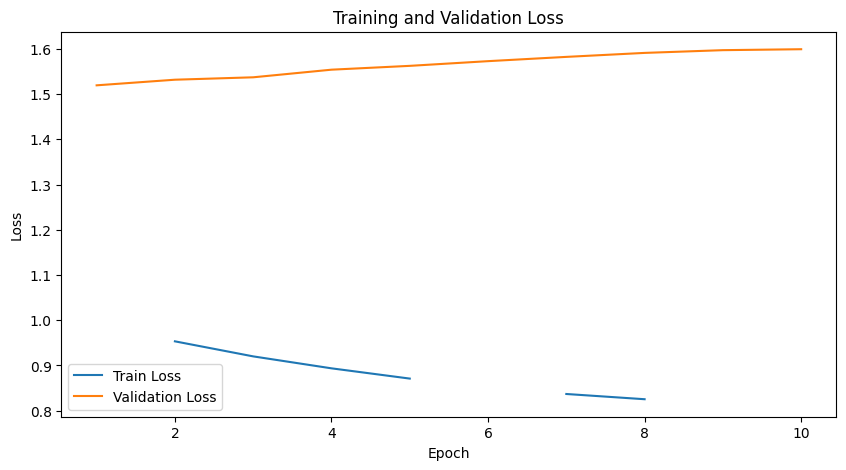

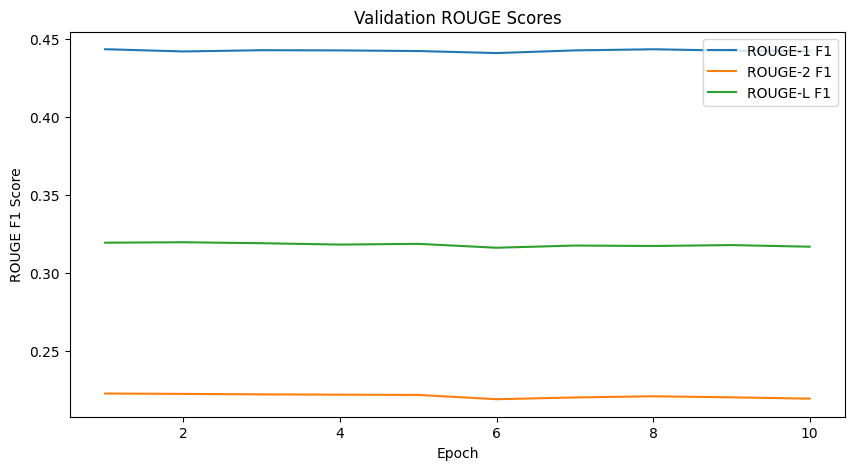

In [12]:
def main(train_subset, val_subset, model, device):
    batch_size = 4
    model = model.to(device)
    lr = 2e-5
    epochs = 10

    train_loader, val_loader = loader(batch_size, train_subset, val_subset)

    optimizer = AdamW(model.parameters(), lr=lr)
    T_max = len(train_loader)
    num_training_steps = epochs * T_max
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    rouge_metric = load("rouge", use_stemmer=True)
    scaler = torch.cuda.amp.GradScaler()



    # Lists to record metrics
    train_losses = []
    val_losses = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, scaler)
        print(f"Train Loss: {train_loss:.4f}")
        train_losses.append(train_loss)

        val_loss, val_rouge = evaluate_epoch(model, val_loader, device, tokenizer, rouge_metric)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)

        # Extract ROUGE scores; adjust based on output structure
        if isinstance(val_rouge, dict):
            if isinstance(val_rouge.get('rouge1', None), dict):
                rouge1 = val_rouge['rouge1']['fmeasure']
                rouge2 = val_rouge['rouge2']['fmeasure']
                rougeL = val_rouge['rougeL']['fmeasure']
            else:
                rouge1 = val_rouge['rouge1']
                rouge2 = val_rouge['rouge2']
                rougeL = val_rouge['rougeL']
        else:
            rouge1 = rouge2 = rougeL = None

        if rouge1 is not None:
            rouge1_scores.append(rouge1)
            rouge2_scores.append(rouge2)
            rougeL_scores.append(rougeL)

        print("ROUGE metric output:", val_rouge)
        if rouge1 is not None:
            print(f"Val ROUGE-1 F1: {rouge1:.4f}")
            print(f"Val ROUGE-2 F1: {rouge2:.4f}")
            print(f"Val ROUGE-L F1: {rougeL:.4f}")
        else:
            print(f"Validation ROUGE: {val_rouge}")

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot ROUGE Scores
    if rouge1_scores:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs+1), rouge1_scores, label="ROUGE-1 F1")
        plt.plot(range(1, epochs+1), rouge2_scores, label="ROUGE-2 F1")
        plt.plot(range(1, epochs+1), rougeL_scores, label="ROUGE-L F1")
        plt.xlabel("Epoch")
        plt.ylabel("ROUGE F1 Score")
        plt.title("Validation ROUGE Scores")
        plt.legend()
        plt.show()


if __name__ == "__main__":
    main(train_subset, val_subset, model, device)
